In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 500
n = 256
l = 20.0

t = np.linspace(0,3,m)
x = linspace(-l/2,l/2,n+1)[0:n]

def nls_rhs(ut_sep, t, params):
    
    n, k = params
    ut = ut_sep[0:n] + 1j*ut_sep[n:]
    u = ifft(ut)
    deriv = -1j/2.0*(k**2)*ut + 1j*fft((abs(u)**2)*u)
    return np.hstack([real(deriv),imag(deriv)])

k = 2*np.pi*numpy.fft.fftfreq(n, d = float(l)/n)
params = (n, k)

u0 = 2*np.cosh(x)**-1
ut0= np.hstack([real(fft(u0)),imag(fft(u0))])
ut = odeint(nls_rhs, ut0, t, args=(params,))
ut = (ut[:,0:n] + 1j*ut[:,n:]).T
    
u = np.zeros((n,m), dtype = complex64)
for j in range(m):
    u[:,j]=ifft(ut[:,j]);

(0.0, 3.0)

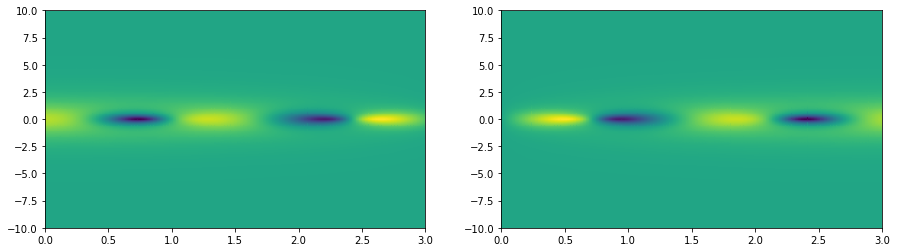

In [3]:
figure(figsize = (15,4))

xx,tt = np.meshgrid(x,t)

subplot(1,2,1)
pcolor(tt,xx,np.real(u).T)
ylim([-l/2,l/2])
xlim([t[0], t[-1]])

subplot(1,2,2)
pcolor(tt,xx,np.imag(u).T)
ylim([-l/2,l/2])
xlim([t[0], t[-1]])

In [4]:
noise_level = [0.01*np.std(u[j,:]) for j in range(n)]
measurement_noise = np.vstack([noise_level[j]*np.random.randn(m) for j in range(n)]) / np.sqrt(2) + \
                             1j*np.vstack([noise_level[j]*np.random.randn(m) for j in range(n)]) / np.sqrt(2)
        
v1 = u + np.sqrt(1)*measurement_noise
v10 = u + np.sqrt(10)*measurement_noise
v50 = u + np.sqrt(50)*measurement_noise
v100 = u + np.sqrt(100)*measurement_noise

(0.0, 3.0)

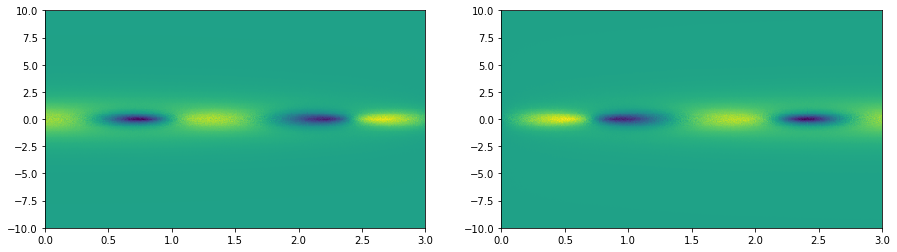

In [5]:
figure(figsize = (15,4))

subplot(1,2,1)
pcolor(tt,xx,np.real(v50).T)
ylim([-l/2,l/2])
xlim([t[0], t[-1]])

subplot(1,2,2)
pcolor(tt,xx,np.imag(v50).T)
ylim([-l/2,l/2])
xlim([t[0], t[-1]])

In [6]:
U,S,Vt = np.linalg.svd(u, full_matrices=False)
Un1,Sn1,Vtn1 = np.linalg.svd(v1, full_matrices=False)
Un10,Sn10,Vtn10 = np.linalg.svd(v10, full_matrices=False)
Un50,Sn50,Vtn50 = np.linalg.svd(v50, full_matrices=False)
Un100,Sn100,Vtn100 = np.linalg.svd(v100, full_matrices=False)

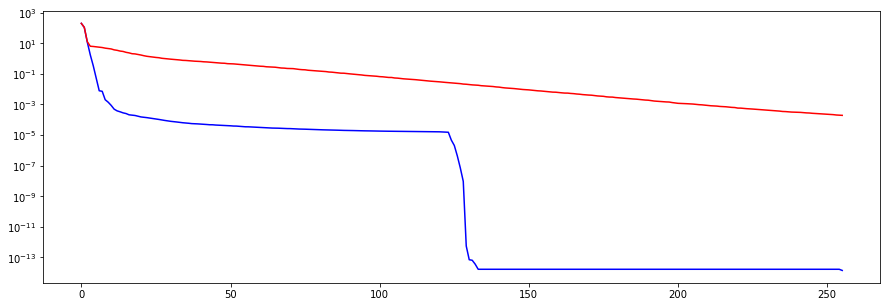

In [7]:
figure(figsize = (15,5))

semilogy(S, 'b')
semilogy(Sn100, 'r')
# plot([0,50], [tau,tau], 'k')

In [8]:
def tf_shift(x, s):
    n,m = tf.shape(x).eval()        
    if s == 0: return x
    elif s>0: return tf.concat([tf.slice(x,[s,0],[n-s,m]),tf.slice(x,[0,0],[s,m])], axis = 0)
    else: return tf.concat([tf.slice(x,[n+s,0],[-s,m]),tf.slice(x,[0,0],[n+s,m])], axis = 0)

dx = x[1]-x[0]

def tf_nls(u_split):
    
    n2,m = tf.shape(u_split).eval()
    n = int(n2/2)
    
    ur = tf.slice(u_split, [0,0], [n,m])
    ui = tf.slice(u_split, [n,0], [n,m])
    
    ur_xx = (tf_shift(ur,1)+tf_shift(ur,-1)-2*ur)/dx**2
    ui_xx = (tf_shift(ui,1)+tf_shift(ui,-1)-2*ui)/dx**2

    absu2 = ur**2+ui**2

    ur_t = -ui_xx/2 - absu2*ui
    ui_t = ur_xx/2 + absu2*ur
    
    return tf.concat([ur_t, ui_t], axis = 0)

def tf_nls(u_split):
    
    n2,m = tf.shape(u_split).eval()
    n = int(n2/2)
    
    ur = tf.slice(u_split, [0,0], [n,m])
    ui = tf.slice(u_split, [n,0], [n,m])
    
    # Eighth order finite difference
    c = [-1/560,8/315,-1/5,8/5,-205/72,8/5,-1/5,8/315,-1/560]
    s = np.arange(-4,5) 
    
    ur_xx = tf.add_n([c[j]*tf_shift(ur,s[j]) for j in range(9)])/dx**2
    ui_xx = tf.add_n([c[j]*tf_shift(ui,s[j]) for j in range(9)])/dx**2

    absu2 = ur**2+ui**2

    ur_t = -ui_xx/2 - absu2*ui
    ui_t = ur_xx/2 + absu2*ur
    
    return tf.concat([ur_t, ui_t], axis = 0)

In [9]:
Sigmas = []
Us = []

for v in [v1,v10,v50,v100]:
    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()

    v_sep = np.vstack([np.real(v), np.imag(v)]).astype(np.float64)
    optimizer, u_hat_tf, cost = create_computational_graph(v_sep, t, tf_nls, method = 'Gauss3')

    init = tf.global_variables_initializer()
    sess.run(init)

    optimizer.minimize(sess)
    
    u_hat_split = u_hat_tf.eval()
    u_hat = u_hat_split[:n,:] + 1j*u_hat_split[n:,:]
    
    sess.close()
    
    Ud, Sd, Vtd = np.linalg.svd(u_hat, full_matrices=False)
    
    Sigmas.append(Sd)
    Us.append(Ud)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000002
  Number of iterations: 4098
  Number of functions evaluations: 4133
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000001
  Number of iterations: 4768
  Number of functions evaluations: 4815
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000001
  Number of iterations: 5858
  Number of functions evaluations: 5904
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000004
  Number of iterations: 3891
  Number of functions evaluations: 3927


In [ ]:
# save results to disk
save_path = "./saved_data/"

# Save results to JSON files
if True:
    np.save(save_path+"NLS_POD_svd.npy", {'U_noisy' : [Un1,Un10,Un50,Un100], \
                                          'Sigma_noisy' : [Sn1,Sn10,Sn50,Sn100], \
                                          'U_smoothed' : [Us], \
                                          'Sigma_smoothed' : [Sigmas]})
    
# Load results from JSON files
if False:
    svd_results = np.load(save_path+"NLS_POD_svd.npy")

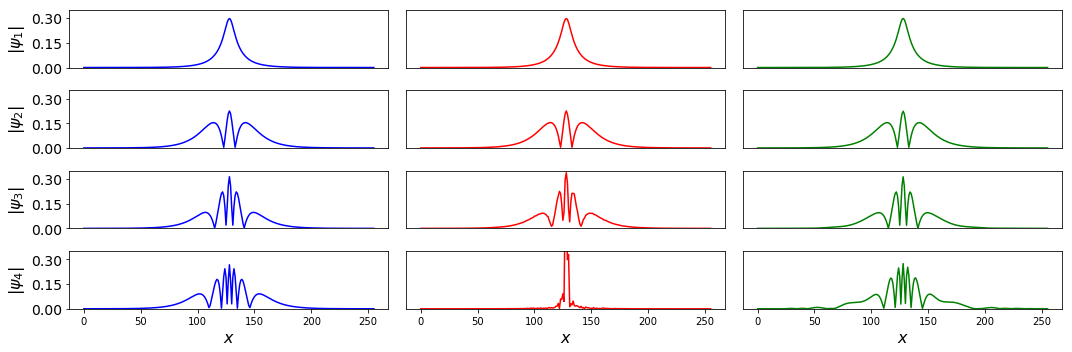

In [11]:
figure(figsize = (15,5))

num_modes = 4
colors = ['b', 'b', 'b', 'b', 'y']

for j in range(num_modes):
    subplot(num_modes, 3, j*3+1)
    plot(abs(U[:,j]), 'b')
    ylabel(r'$|\psi_{'+str(j+1)+'}|$', fontsize = 16)
    if j != num_modes-1: xticks([])
    yticks([0,0.15,0.3], fontsize = 14)
    ylim([0,0.35])

xlabel(r'$x$', fontsize = 16)
    
for j in range(num_modes):
    subplot(num_modes, 3, j*3+2)
    plot(abs(Un100[:,j]), 'r')
    if j != num_modes-1: xticks([])
    yticks([])
    ylim([0,0.35])

xlabel(r'$x$', fontsize = 16)

for j in range(num_modes):
    subplot(num_modes, 3, j*3+3)
    plot(abs(Us[3][:,j]), 'g')
    if j != num_modes-1: xticks([])
    yticks([])
    ylim([0,0.35])

xlabel(r'$x$', fontsize = 16)
tight_layout()

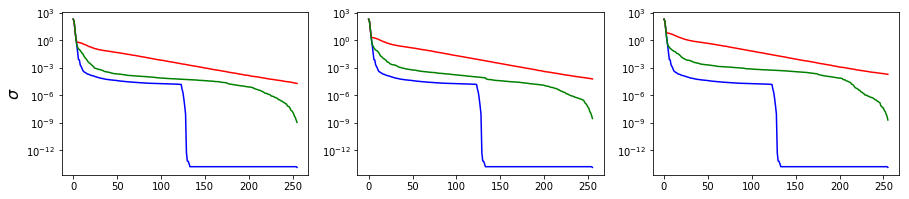

In [12]:
figure(figsize = (15,3))

subplot(1,3,1)
semilogy(S, 'b')
semilogy(Sn1, 'r')
semilogy(Sigmas[0], 'g')
ylabel(r'$\sigma$', fontsize = 16)

subplot(1,3,2)
semilogy(S, 'b')
semilogy(Sn10, 'r')
semilogy(Sigmas[1], 'g')

subplot(1,3,3)
semilogy(S, 'b')
semilogy(Sn100, 'r')
semilogy(Sigmas[3], 'g')